In [1]:
from src.services.data_converter_service import DataConverterService
from src.services.crop_image_service import CropImageService
from src.services.predict_symbols_service import PredictSymbolsService
from src.utils.segment_image_dimensions import segment_image_dimensions
from src.utils.convert_points_to_bounding_box import convert_points_to_bounding_box
from ultralytics import YOLO
from config import config

from IPython.display import display
from PIL import Image


# a better option would be to go through all the bounding box that are in simlar group (meaning not to far away from each other) and calculate the highest area amongst them.
# as a result we won't need the class sizes variable.


# class areas.
class_sizes = {'21': 1985, '2': 5415, '18': 6969, '26': 17849, '8': 7037, '20': 6110, '25': 6532, '32': 16411, '28': 17179, '7': 6771, '9': 6689, '12': 5510, '22': 5795, '24': 2808, '11': 6129, '23': 8645, '29': 17181, '4': 6132, '31': 16001, '5': 4808, '15': 3737, '17': 5721, '19': 6769, '30': 11940, '16': 3564, '13': 6558, '1': 4575, '6': 3126, '10': 8179, '27': 18761, '14': 13607, '3': 6903}



data_converter_service = DataConverterService()
datapoint = data_converter_service.load_single_datapoint(str(21))
image = Image.open(datapoint.image_path)

In [2]:

def load_model():
    return YOLO(config.model_path)


def get_bounding_boxes_prediction():
    total_bounding_boxes_with_shifts = []
    for shift in range(0, 500, 100):
        print("\n\nstarting out with shift: ", shift)
        
        dimensions = segment_image_dimensions(
            image=image,
            chunk_size=1080,
            shift=shift
        )

        total_bounding_boxes = []
        for index, dim in enumerate(dimensions):
            crop_service = CropImageService(
                image_path=datapoint.image_path,
                cropped_dimensions=convert_points_to_bounding_box(dim)
            )
            # cropped image dimensions can come from here
            chunk = crop_service.crop_image()
            model = load_model()
            
            result = model(source=chunk)

            bboxes = result[0].boxes
            
            for box in bboxes:
                # values of bounding box w.r.t the cropped image
                x_min, y_min, x_max, y_max = box.xyxy[0].tolist()

                c = model.names[int(box.cls[0])]
                x1_full = x_min + dim[0]
                y1_full = y_min + dim[1]
                x2_full = x_max + dim[0]
                y2_full = y_max + dim[1]

                b = [x1_full, y1_full, x2_full, y2_full]

                total_bounding_boxes.append((b, c))

        # the shifts are ignored for now, we only consider the first shift. 
        total_bounding_boxes_with_shifts = [*total_bounding_boxes_with_shifts, *total_bounding_boxes]

    # new_total_bounding_boxes_with_shifts = []
    # for t in total_bounding_boxes_with_shifts:
    #     [x1, y1, x2, y2] = t[0]
    #     class_type = t[1]
    #     # width and height of the predicted classes.
    #     width, height = (abs(x2 - x1), abs(y2 - y1))

    #     if class_sizes[class_type] is None:
    #         continue

    #     if abs(width - class_sizes[class_type][0]) < 10 and abs(height - class_sizes[class_type][1]) < 10:
    #         new_total_bounding_boxes_with_shifts.append(
    #             t
    #         )
    
    return total_bounding_boxes_with_shifts

In [3]:
total = get_bounding_boxes_prediction()



starting out with shift:  0

0: 1088x1088 1 32, 140.7ms
Speed: 5.9ms preprocess, 140.7ms inference, 0.0ms postprocess per image at shape (1, 3, 1088, 1088)

0: 1088x1088 2 10s, 1 15, 2 19s, 1 23, 1 24, 1 31, 102.0ms
Speed: 7.4ms preprocess, 102.0ms inference, 0.0ms postprocess per image at shape (1, 3, 1088, 1088)

0: 1088x1088 2 8s, 1 19, 1 20, 1 31, 1 32, 95.2ms
Speed: 8.0ms preprocess, 95.2ms inference, 0.0ms postprocess per image at shape (1, 3, 1088, 1088)

0: 1088x1088 1 8, 92.3ms
Speed: 6.8ms preprocess, 92.3ms inference, 0.0ms postprocess per image at shape (1, 3, 1088, 1088)

0: 256x1088 (no detections), 39.8ms
Speed: 2.0ms preprocess, 39.8ms inference, 0.0ms postprocess per image at shape (1, 3, 256, 1088)

0: 1088x1088 1 9, 1 14, 3 17s, 1 31, 1 32, 83.3ms
Speed: 6.0ms preprocess, 83.3ms inference, 0.0ms postprocess per image at shape (1, 3, 1088, 1088)

0: 1088x1088 1 5, 2 6s, 1 11, 1 21, 1 23, 1 24, 1 25, 1 26, 1 28, 1 29, 2 30s, 102.4ms
Speed: 8.8ms preprocess, 102.4ms i

In [11]:
# filtering logic with area.

# its better if this part of code should not be used because grouping gives a better result anyway

def filter_condition(box):
    [x1, y1, x2, y2] = box[0]
    class_type = box[1]

    width_pred, height_pred = (abs(x2 - x1), abs(y2 - y1))
    pred_area = width_pred * height_pred
    actual_area = class_sizes[class_type]

    return pred_area/actual_area > 0.5

total_filtered = list(filter(filter_condition, total))

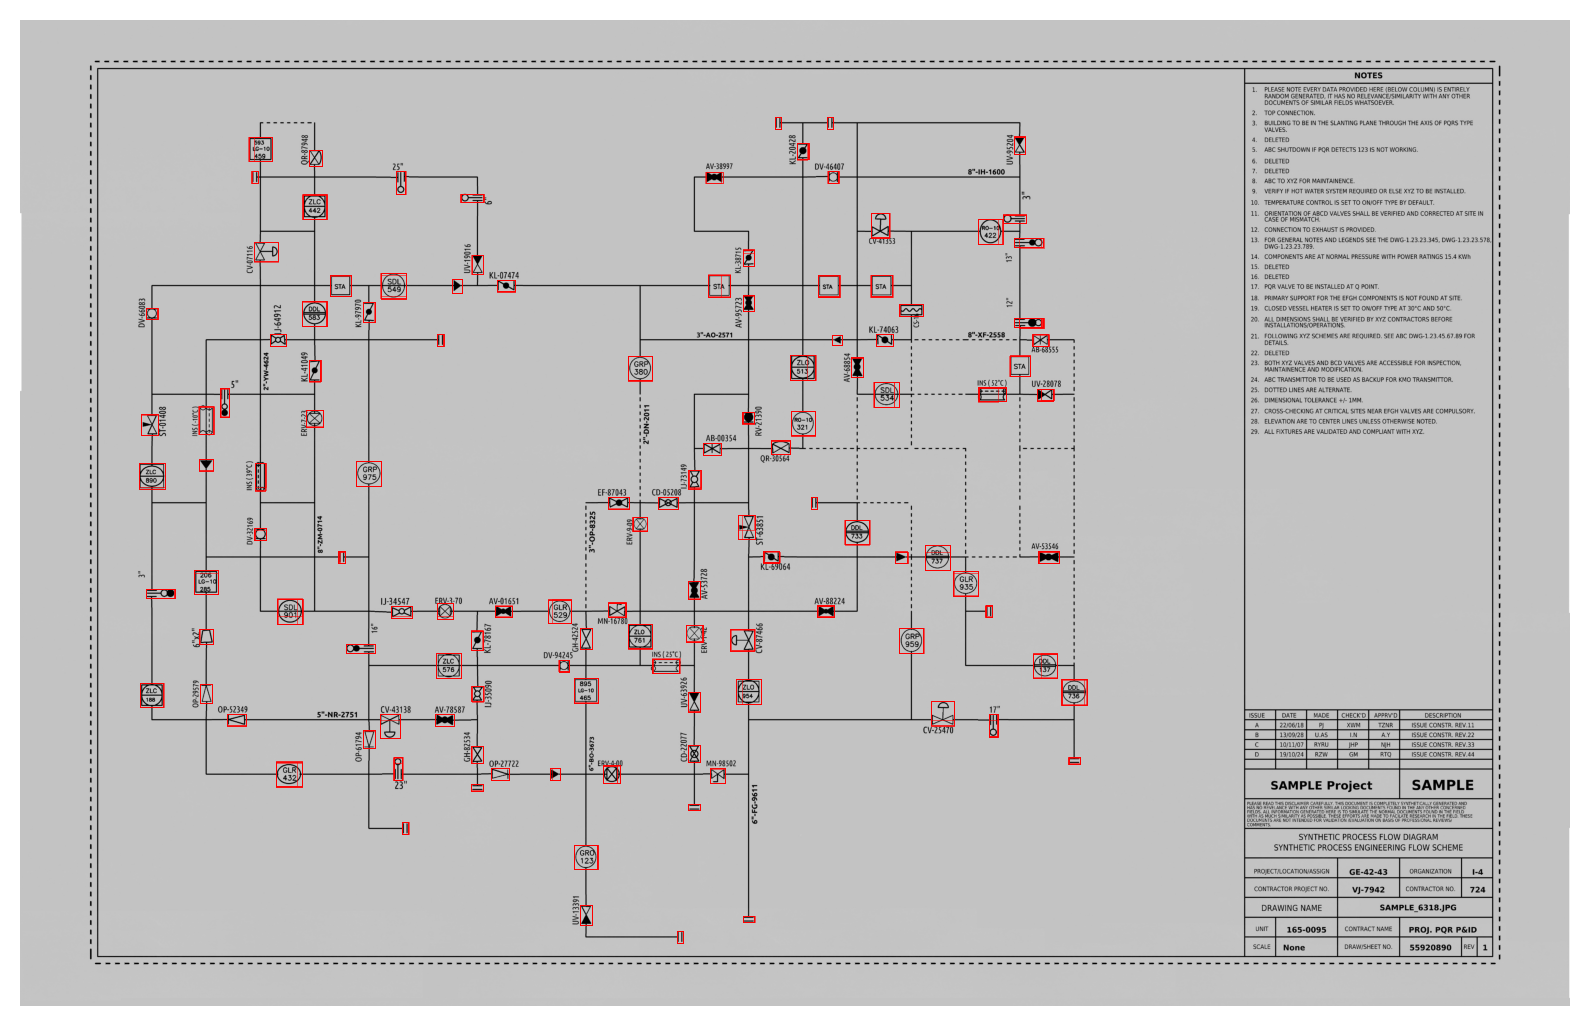

In [12]:
from src.services.image_display_serivce import ImageDisplayService


def bbox_name(d):
    bbox = convert_points_to_bounding_box([d[0][0], d[0][1], d[0][2], d[0][3]])
    # bbox.name = d[1]
    return bbox

display_service = ImageDisplayService(
    image_path=datapoint.image_path,
    bounding_boxes=list(map(bbox_name, total_filtered))
)

display_service.display_image_with_bbox()

In [81]:
# filter logic with certain distance threashold.

def filter_condition(box):
    [x1, y1, x2, y2] = box[0]
    class_type = box[1]

    width_pred, height_pred = (abs(x2 - x1), abs(y2 - y1))
    width_actual, height_actual = class_sizes[class_type]

    if class_type == '21':
        print(width_pred, height_pred, class_type)
        print(abs(width_pred - width_actual) < 10, abs(height_pred - height_actual) < 10)

    return True # abs(width_pred - width_actual) < 10

random = list(filter(filter_condition, total))

TypeError: cannot unpack non-iterable int object

In [ ]:
total_filtered[0:2]

[([1017.2935791015625,
   993.7249145507812,
   1063.78955078125,
   1079.9844970703125],
  '17'),
 ([1017.2322387695312, 994.2972412109375, 1063.761474609375, 1080.0], '17')]

In [6]:
from typing import List, Tuple
from collections import defaultdict

from src.utils.calculate_distance_between_rectangles import calculate_distance_between_rectangles


def group_closest_points(bounding_boxes: Tuple[List[int], str], threshold: int):
    groups = defaultdict(list)
    visited = set()
    group_id = 0

    for i, bbox_from in enumerate(bounding_boxes):
        if i in visited:
            continue

        # Start a new group
        group_id += 1
        groups[group_id].append(bbox_from)
        visited.add(i)

        # Compare with remaining points
        for j, bbox_to in enumerate(bounding_boxes):
            bbox_from_point = bbox_from[0]
            bbox_to_point = bbox_to[0]
            if j not in visited and calculate_distance_between_rectangles(bbox_from_point, bbox_to_point) <= threshold:
                groups[group_id].append(bbox_to)
                visited.add(j)

    return dict(groups)


In [13]:
connected_points_dict = group_closest_points(total_filtered, 50)

In [14]:
def calculate_bbox_area(bbox):
    x, y, _x, _y = bbox
    return abs(_y - y) * abs(_x - x)


new_bounding_box_array = []

for key in connected_points_dict.keys():
    bboxes = connected_points_dict[key]

    max_area_index = 0
    for index, bbox in enumerate(bboxes):
        bbox_point = bbox[0]
        if calculate_bbox_area(bbox[0]) > calculate_bbox_area(bboxes[max_area_index][0]):
            max_area_index = index 
    
    new_bounding_box_array.append(
        bboxes[max_area_index]
    )

new_bounding_box_array

[([825.1002807617188,
   1789.5933837890625,
   895.6953735351562,
   1916.8440551757812],
  '23'),
 ([825.0195922851562, 2032.7205200195312, 894.17529296875, 2084.3803100585938],
  '24'),
 ([581.1685791015625,
   1333.6909942626953,
   635.9635009765625,
   1386.4322814941406],
  '15'),
 ([924.9179077148438,
   1704.7727508544922,
   965.6624145507812,
   1837.2800903320312],
  '19'),
 ([560.2130737304688,
   1825.6091918945312,
   637.3358154296875,
   1922.395751953125],
  '10'),
 ([549.3573303222656,
   2051.257568359375,
   669.1991882324219,
   2171.0156860351562],
  '31'),
 ([828.9705810546875,
   2817.4573364257812,
   892.8571166992188,
   2886.5523071289062],
  '20'),
 ([580.2004852294922, 2632.0113525390625, 714.7341003417969, 2674.88916015625],
  '19'),
 ([554.9750671386719, 3068.0126953125, 663.0317077636719, 3178.5726318359375],
  '31'),
 ([832.3936157226562, 3071.6754760742188, 888.3558349609375, 3158.62158203125],
  '8'),
 ([805.2796936035156, 2544.2578125, 915.38366699

In [15]:
len(new_bounding_box_array)

123

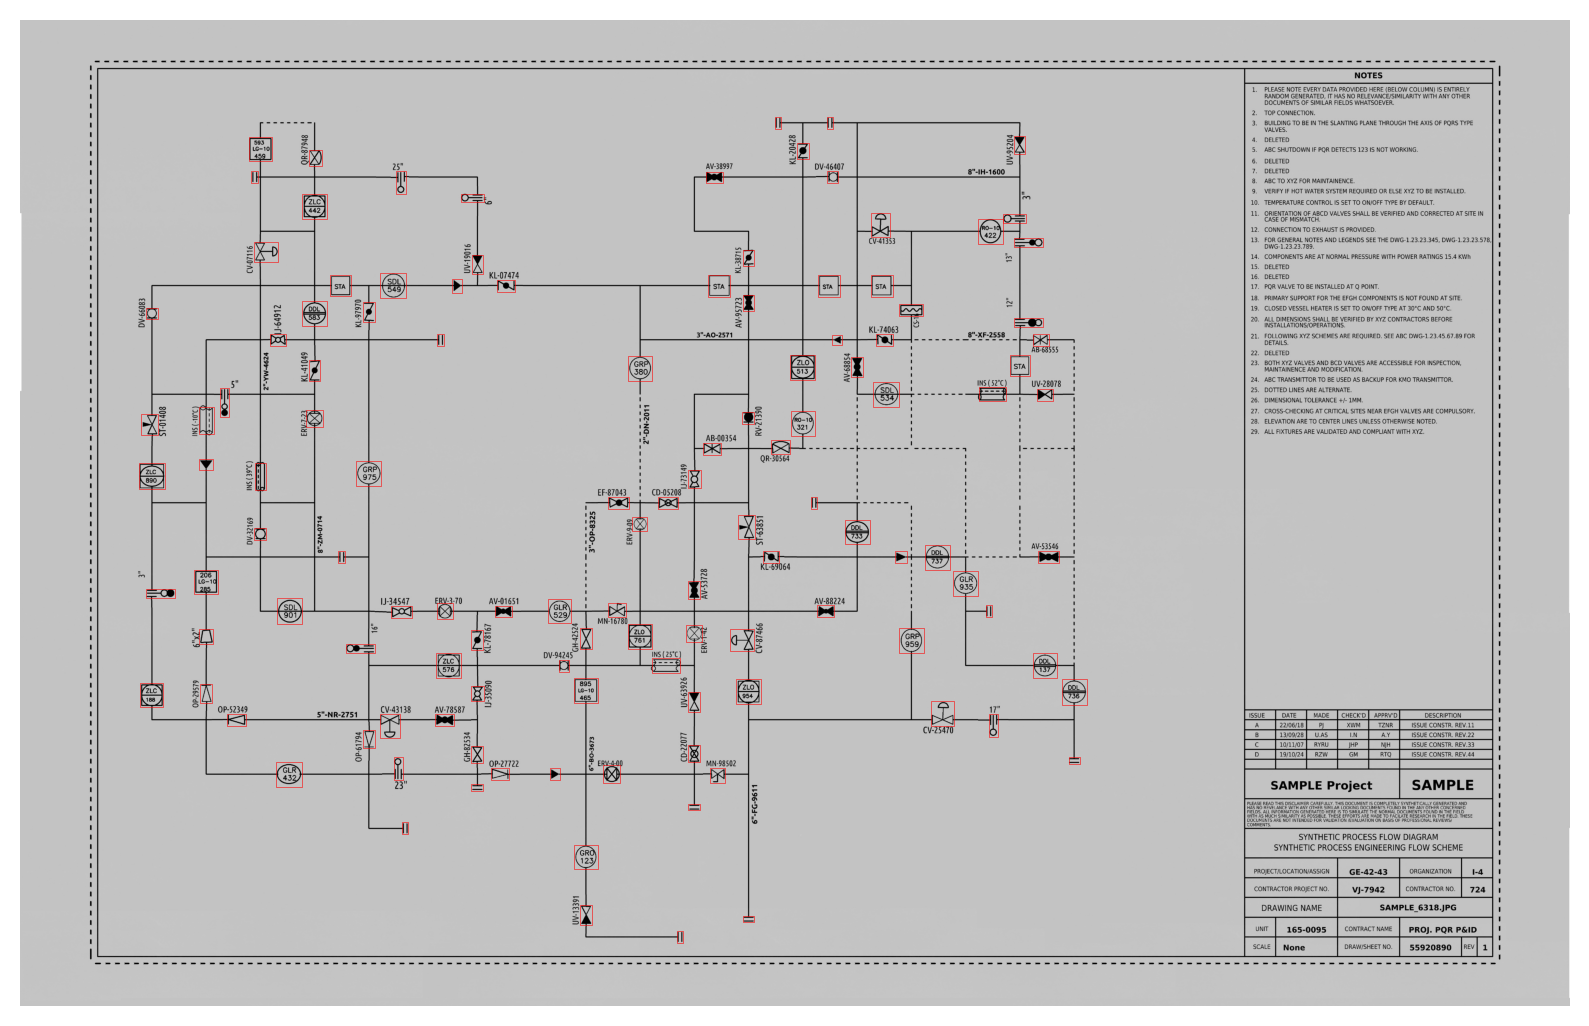

In [16]:
display_service_with_filteration = ImageDisplayService(
    image_path=datapoint.image_path,
    bounding_boxes=list(map(bbox_name, new_bounding_box_array))
)

display_service_with_filteration.display_image_with_bbox()